export a unique set of data synthesized

In [1]:
    import requests_cache, nltk.tokenize    
    cache = platformdirs.user_cache_path("a11yhood") / "thingiverse"
    search_session = requests_cache.CachedSession(cache / "search_responses.sqlite")
    thing_session = requests_cache.CachedSession(cache / "thing_responses.sqlite")

In [2]:
    def word_cloud(freq): return (
        __import__("wordcloud").WordCloud()
        .generate_from_frequencies(dict(freq))
        .to_image()
    )

In [3]:
    def get_thing_details_tidy(df, index):
        df = df[df.columns.difference(index.columns)]
        df = df.join(
            df.pop("zip_data").series().stack().explode().apply(operator.itemgetter("url")).groupby(level=0).agg(list).rename("files")
        )
        # the default image is in the files
        df.pop("default_image");
        df.pop("edu_details_parts");
        df.pop("education");
        df.pop("description_html");
        # TODO there is information in details_parts than can be extracted for search.
        details_parts = df.pop("details_parts").explode().apply(Series).set_index("type", append=True)
        # detail_parts is segmented string info we cram into  a single block
        details_parts = details_parts.join(
            details_parts.data.explode().dropna().apply(Series).fillna("").apply("\n".join, axis=1).rename("parts")
        )
        details_parts = details_parts.reset_index(1, drop=True)
        df = df.join(
            (("<h2>" + details_parts["name"] + "</h2>") + "\n" + details_parts["parts"]).dropna().groupby(level=0).agg("\n".join).rename("details_parts")
        )
        df["ancestors"] = df.ancestors.explode().dropna().series().public_url.groupby(level=0).agg(list)
        return df

In [4]:
    things = (
        df := Series(search_session.cache.responses)
        .apply(operator.methodcaller("json"))
        .apply(operator.itemgetter("hits"))
        .explode()
        .apply(Series)
        .set_index("id")
    ).join(
        Series(thing_session.cache.responses)
        .apply(operator.methodcaller("json"))
        .apply(Series).pipe(get_thing_details_tidy, df)
        .set_index("id")
    )
    things.tags = (
        things.tags
        .explode()
        .dropna()
        .apply(operator.itemgetter("name"))
        .groupby(pandas.Grouper(level=0))
        .agg(list)
    )

## ravelry

In [5]:
    import requests_cache, platformdirs
    cache = platformdirs.user_cache_path("a11yhood") / "ravelry"
    search_cache = requests_cache.CachedSession(cache / "search_responses.json")
    patterns_cache = requests_cache.CachedSession(cache / "patterns_responses.json")

In [6]:
    patterns = (
        df := Series(search_cache.cache.responses)
        .apply(operator.methodcaller("json"))
        .apply(operator.itemgetter("patterns"))
        .explode()
        .apply(Series)
        .set_index("id")
    ).join(
        (
            g:= Series(patterns_cache.cache.responses)
            .apply(operator.methodcaller("json"))
            .apply(operator.itemgetter("patterns"))
            .apply(dict.values)
            .explode()
            .apply(Series)
            # .explode()
            .set_index("id")
        )[g.columns.difference(df.columns)]
    )

In [7]:
    patterns = patterns.join(pandas.concat([
        patterns.pattern_categories.explode().apply(Series).name,
        patterns.pattern_attributes.explode().apply(Series).permalink.str.replace("-", " ")
    ], axis=0).groupby(level=0).agg(list).rename("tags"))

## github

In [8]:
    cache = platformdirs.user_cache_path("a11yhood") / "github"
    search_cache = cache / "search_responses.pkl"

In [9]:
    with __import__("shelve").open(search_cache) as db:
        (
            repos := Series(db)
            .apply(operator.itemgetter("data"))
            .apply(operator.itemgetter("search"))
            .apply(operator.itemgetter("edges"))
            .explode()
            .apply(operator.itemgetter("node"))
            .apply(Series).set_index("id")
        )

    repos["tags"] = (
        repos.repositoryTopics
        .apply(operator.itemgetter("edges"))
        .explode()
        .apply(operator.itemgetter("node"))
        .apply(operator.itemgetter("topic"))
        .apply(operator.itemgetter("name"))
        .str.replace("-", " ")
        .groupby(pandas.Grouper(level=0)).agg(list)
    )

    repos["issues"] = repos["issues"].apply(get("totalCount"))
    repos["pullRequests"] = repos["pullRequests"].apply(get("totalCount"))
    repos = repos.drop(columns="licenseInfo").join(repos["licenseInfo"].dropna().apply(get("name")))

## text analysis

`all` is a synthesis of each of the services with >1400 entries

In [10]:
    (all := pandas.concat([
        (r := repos.set_index("url"))
        ["description stargazerCount forkCount licenseInfo tags".split()]
        .join(r.index.to_series().str.rpartition("/")[2].rename("name"))
        .rename(columns=dict(licenseInfo="license")),
        things.set_index("public_url")["name tags license description".split()],
        patterns.set_index(
            "https://www.ravelry.com/patterns/library/" + patterns.permalink
        )["name notes tags".split()].rename(columns=dict(notes="description"))
    ], axis=0))

,description,stargazerCount,forkCount,license,tags,name
https://github.com/ai-collection/ai-collection,The Generative AI Landscape - A Collection of ...,7916.0,780.0,MIT License,"[artificial intelligence, collections, ai, ass...",ai-collection
https://github.com/OptiKey/OptiKey,OptiKey - Full computer control and speech wit...,4314.0,507.0,GNU General Public License v3.0,"[eye tracking, eyetracking, eye tracker, eyes,...",OptiKey
https://github.com/brunopulis/awesome-a11y,A curate list about A11Y,1843.0,145.0,Creative Commons Zero v1.0 Universal,"[accessibility, wai aria, wcag, a11y, awesome ...",awesome-a11y
https://github.com/Stypox/dicio-android,Dicio assistant app for Android,886.0,81.0,GNU General Public License v3.0,"[assistant, assistive technology, personal ass...",dicio-android
https://github.com/cboard-org/cboard,Augmentative and Alternative Communication (AA...,667.0,180.0,GNU General Public License v3.0,"[aac, autism, cerebral palsy, progressive web ...",cboard
...,...,...,...,...,...,...
https://www.ravelry.com/patterns/library/leper-bandage-a-378,,NaN,NaN,NaN,"[Medical, unisex, child, teen, adult, written ...",Leper Bandage A-378
https://www.ravelry.com/patterns/library/reusable-tampons,**No longer available**\r\n\r\n,NaN,NaN,NaN,"[Medical, written pattern]",Reusable Tampons
https://www.ravelry.com/patterns/library/ankle-wrap-ice-packs,Pattern removed for no longer reaching the lev...,NaN,NaN,NaN,"[Medical, seamed, chart, written pattern, work...",Ankle Wrap Ice Packs
https://www.ravelry.com/patterns/library/home-made-ace-bandages,,NaN,NaN,NaN,"[Medical, one piece, seamless, written pattern]","Home Made ""ACE"" Bandages"


In [11]:
    counts = all.tags.explode().str.lower().value_counts()
    (tags := counts.head(100)).to_frame("tags").T.style.set_caption(
        "aggregated tags from all of the services"
    )

tags,assistive technology,written pattern,screen reader,accessibility,medical,wai aria,wcag,in the round,one piece,medical device accessory,worked flat,therapy aid,other,adaptive,adult,seamless,unisex,phototutorial,seamed,medical device access,ribbed,bottom up,3 dimensional,assistivetech,stripes colorwork,female,teen,disability,textured,animal,chart,other accessibility,rectangle,video tutorial,openat,amigurumi,child,python3,top down,chrome extension,assistive device,a11y,firefox extension,mature,top cuff down,haskell,opera extension,scalameta,scala,neovim plugin,buttonholes,firefox addon,javaee,wordpress plugin,acessibility,muff,mid-calf,python,"beanie, toque",arduino,buttoned,bobble or popcorn,icord,toe up,toddler,assistive,fitted,aac,reversible,lace,male,cables,preemie,shawl / wrap,mobility aid accessory,kitchener,nvda,open source,3d printing,ai,technology,heel flap,android,sideways,newborn size,noshaping,baby,machine learning,communication,ipad,three needle bind,schematic,speech,disabled,artificial intelligence,assistant,mittens,post stitch,fingerless gloves/mitts,slipped stitches
tags,752,585,475,432,389,325,325,272,249,214,212,204,192,192,177,167,131,124,122,100,91,90,89,74,68,66,65,57,56,54,51,50,49,48,46,45,45,40,36,35,34,34,33,33,33,32,32,32,32,32,32,32,32,32,32,31,29,29,27,27,26,25,25,25,25,24,24,23,22,21,20,20,20,20,20,19,19,18,18,18,17,17,16,16,16,16,15,15,15,15,15,15,14,14,14,14,14,13,13,13


a word cloud of the tags

top 100 tags

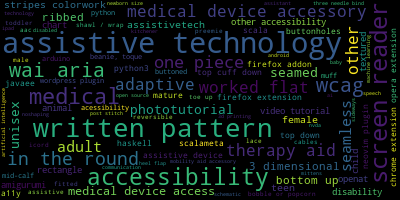

In [12]:
    tags.pipe(word_cloud)

all tags

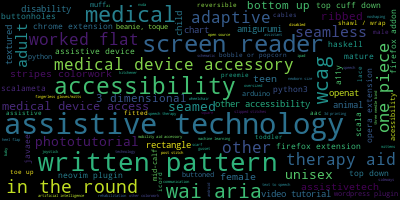

In [13]:
    counts.pipe(word_cloud)

## text analysis

In [14]:
    words = (
        all.description.dropna()
        # .str.lower()
        .apply(nltk.tokenize.sent_tokenize)
        .explode()
        .dropna()
        .apply(nltk.tokenize.word_tokenize)
        .apply(compose(lambda x: pipe(x, map(list), partial(DataFrame, columns="word pos".split())), nltk.pos_tag))
        # .str.lower()
    )

    words = pandas.concat(pipe(words.items(), dict)).reset_index(-1, drop=True)
    words["word"] = words["word"].str.lower()

In [15]:
    words = words.assign(
        stop=words.word.apply((
            "http https nbsp".split() + 
            nltk.corpus.stopwords.words("english")
        ).__contains__),
        alpha=words.word.apply(compose(str.isalpha, get(0)))
    )
    words = words.assign(
        valid=numpy.logical_and(~words.stop, words.alpha)
    )    

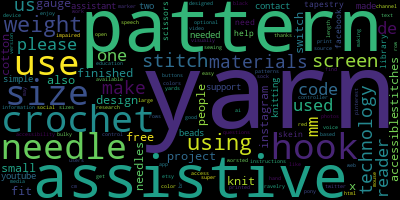

In [16]:
    words[words.valid].word.value_counts().pipe(word_cloud)

In [17]:
    words[words.valid].word.value_counts().head(100).to_frame().T.style.set_caption(
        "aggregated words from all of the services"
    )

word,yarn,pattern,assistive,crochet,use,hook,needle,size,weight,using,stitch,screen,technology,materials,make,us,please,one,de,mm,reader,used,code,project,cotton,gauge,instagram,finished,fit,design,small,free,people,switch,stitches,x,knit,needles,also,accessible,support,needed,made,beads,contact,knitting,two,youtube,assistant,simple,tapestry,facebook,need,help,scissors,library,skein,accessibility,device,optional,available,impaired,worsted,cm,like,questions,designed,br,open,based,etsy,web,html,speech,may,photos,patterns,text,ravelry,rows,buttons,easy,sizes,length,black,making,voice,visually,app,information,education,twitter,color,media,version,ai,source,printed,access,hand
count,152,126,83,74,72,71,69,69,66,66,49,48,44,44,43,43,40,40,38,37,36,36,34,33,33,31,31,30,30,29,29,29,28,28,28,27,27,27,27,26,25,25,25,25,25,25,24,24,24,24,23,23,23,23,23,21,21,21,21,20,20,20,20,20,19,19,19,19,19,18,18,18,18,18,18,18,18,17,17,17,17,17,17,17,17,17,16,16,16,16,16,16,16,16,15,15,15,15,15,15
